In [1]:
import os
print(os.getcwd())
def update_working_directory():
    from pathlib import Path
    p = Path(os.getcwd()).parents[0]
    os.chdir(p)
    print(p)
update_working_directory()

/Users/admin/Projects/doggo/notebooks
/Users/admin/Projects/doggo


# Importing the required libraries

In [37]:
import numpy as np
import pandas as pd
import gym
import time
import math
import statistics
from tqdm import tqdm
import random
from collections import defaultdict
import matplotlib.pyplot as plt

# Building the environment

## Reset

In [3]:
decimals_state = 2
def get_state_id(dog_state):
    return '{:01.4f}_{:01.4f}_{:01.4f}_{}'.format(
        dog_state['food'], dog_state['fat'], dog_state['affection'], dog_state['can_action_be_taken'])

In [4]:
def env_reset():
    
    dog_state = {
        'food': 0.5,
        'fat': 0,
        'affection': 0.5,
        'last_action_taken': 0,
        'minutes_since_last_action': 0,
        'can_action_be_taken': True
        }
    
    dog_state['state_id'] = get_state_id(dog_state)
    
    return dog_state

In [5]:
env_reset()

{'food': 0.5,
 'fat': 0,
 'affection': 0.5,
 'last_action_taken': 0,
 'minutes_since_last_action': 0,
 'can_action_be_taken': True,
 'state_id': '0.5000_0.0000_0.5000_True'}

## Observation and action spaces

In [6]:
# n_states = env.observation_space.n
# n_states = 11*11*11
# n_actions = env.action_space.n
n_actions= 4

## Next state

In [7]:
WALKING_TIME = 15
EATING_TIME = 1
PLAYING_TIME = 4

food_consumption_rate = 1.0 / (30 * 3600)
affection_consumption_rate = 1.0 / (50 * 3600)
walking_fat_converge_rate = 0.2
walking_affection_converge_rate = 0.4
playing_fat_converge_rate = 0.1
playing_affection_converge_rate = 0.20
eating_food_increase = 0.6
eating_fat_increase = 0.25

In [8]:
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier
def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

In [9]:
def apply_decreasing_rate(value: float, rate: float) -> float:
    """
    Apply a decreasing rate to a value
    :param value: current value
    :param rate: per second
    :return: updated value
    """
    return value - (60 * rate)

def converge(value: float, target: float, ratio: float) -> float:
    diff: float = (target - value) * ratio
    return value + diff


def update_food(dog_state):
    update_food = apply_decreasing_rate(dog_state['food'], food_consumption_rate)
    return round_down(max(0.0, update_food), decimals=decimals_state)

def update_fat(dog_state):
    update_fat = dog_state['fat']
    return update_fat

def update_affection(dog_state):
    update_affection = apply_decreasing_rate(dog_state['affection'], affection_consumption_rate)
    return round_down(max(0.0, update_affection), decimals=decimals_state)


def update_if_walking(dog_state):
    update_fat = round_down(converge(dog_state['fat'], 0.0, walking_fat_converge_rate), decimals=decimals_state)
    update_affection = round_up(converge(dog_state['affection'], 1.0, walking_affection_converge_rate), decimals=decimals_state)
    return (update_fat, update_affection)

def update_if_feeding(dog_state):
    update_food = round_up(min(dog_state['food'] + eating_food_increase, 1.0), decimals=decimals_state)
    update_fat = round_up(min(dog_state['fat'] + eating_fat_increase, 1.0), decimals=decimals_state)
    return (update_food, update_fat)

def update_if_playing(dog_state):
    update_fat = round_down(converge(dog_state['fat'], 0.0, playing_fat_converge_rate), decimals=decimals_state)
    update_affection = round_up(converge(dog_state['affection'], 1.0, playing_affection_converge_rate), decimals=decimals_state)
    return (update_fat, update_affection)


def get_happiness(dog_state):
    happiness = min(dog_state['food'], 1.0 - dog_state['fat'], dog_state['affection'])
    return happiness


def update_done(dog_state):
    happiness = get_happiness(dog_state)
    return happiness <= 0.0

In [10]:
# state2, reward1, done, info = env.step(action1)
def env_step(state1, action):
    
    state2 = state1.copy()
    reward_penalty = 0
    
    # Affect of time
    state2['food'] = update_food(state2)
    state2['fat'] = update_fat(state2)
    state2['affection'] = update_affection(state2)
    state2['minutes_since_last_action'] += 1 
    
    # Applying action
    if action != 0:
        if state2['can_action_be_taken']:
            reward_penalty += 0.1
            state2['can_action_be_taken'] = False
            state2['minutes_since_last_action'] = 0
            state2['last_action_taken'] = action
        else:
            reward_penalty += 0.5

    # Affect of actions
    if (state2['last_action_taken'] == 1) & (state2['minutes_since_last_action'] == WALKING_TIME):
        state2['fat'], state2['affection'] = update_if_walking(state2)
        state2['can_action_be_taken'] = True

    if (state2['last_action_taken'] == 2) & (state2['minutes_since_last_action'] == EATING_TIME):
        state2['food'], state2['fat'] = update_if_feeding(state2)
        state2['can_action_be_taken'] = True

    if (state2['last_action_taken'] == 3) & (state2['minutes_since_last_action'] == PLAYING_TIME):
        state2['fat'], state2['affection'] = update_if_playing(state2)
        state2['can_action_be_taken'] = True
                    
    done = update_done(state2)
    if done:
        reward = -10
    else:
        reward = min(state2['food'], 1.0 - state2['fat'], state2['affection']) - reward_penalty
    
    info = None
    
    state2['state_id'] = get_state_id(state2)
    
    return (state2, reward, done, info)

## Render

In [11]:
def env_render(dog_state, action, Q):
    print(dog_state)
    print(action)
    print(Q[dog_state['state_id']])

# Defining utility functions to be used in the learning process

## Initialising Q

In [12]:
def init_Q(n_actions, init_Q_type="ones"):
    """
    @param n_actions the number of actions
    @param type random, ones or zeros for the initialization
    """
    if init_Q_type == "ones":
        default_Q_values = np.ones(n_actions)
    elif init_Q_type == "random":
        default_Q_values = np.random.random(n_actions)
    elif init_Q_type == "zeros":
        default_Q_values = np.zeros(n_actions)
    
    def get_default_Q_values():
        return default_Q_values

    return defaultdict(get_default_Q_values)

## Initialising N

In [13]:
def init_N(n_actions):
    """
    @param n_actions the number of actions
    """
    default_N_values = np.zeros(n_actions)
    
    def get_default_N_values():
        return default_N_values

    return defaultdict(get_default_N_values)

## Choose an action

In [14]:
# Numpy generator
rng = np.random.default_rng()  # Create a default Generator.

In [15]:
def select_best_action(Q_state):
    winner = np.argwhere(Q_state == np.amax(Q_state))
    winner_list = winner.flatten().tolist()
    action = random.choice(winner_list)
    return action

In [16]:
def epsilon_greedy(Q, state_id, n_actions, epsilon):
    """
    @param Q Q values {state, action} -> value
    @param epsilon for exploration
    @param n_actions number of actions
    @param state state at time t
    """
    if rng.uniform(0, 1) < epsilon:
        action = np.random.randint(0, n_actions)
    else:
        action = select_best_action(Q[state_id])
    
    return action

## Discounted reward

In [17]:
def get_discounted_reward(t, l_rewards_episode, gamma):
    l_discounted_reward_episode = [t_prime_reward*(gamma**t_prime) for (t_prime, t_prime_reward) in enumerate(l_rewards_episode[t:])]
    G_k_t = sum(l_discounted_reward_episode)
    return G_k_t

def add_discounted_reward(steps_episode, gamma):
    l_rewards_episode = [step_episode['reward'] for step_episode in steps_episode]
    for (t, step_episode) in enumerate(steps_episode):
        step_episode['discounted_reward'] = get_discounted_reward(t, l_rewards_episode, gamma)

## Update N-matrice

In [18]:
def update_N(N, step_episode, method_monte_carlo, states_already_visited=[]):
    
    state_id = step_episode['state']['state_id']
    action = step_episode['action']
    
    previous_N_value_state = N[state_id].copy()
    
    if method_monte_carlo == 'first_visit':
        if not state_id in states_already_visited:
            new_N_value = N[state_id][action] + 1
            previous_N_value_state[action] = new_N_value
    
    if method_monte_carlo == 'every_visit':
        new_N_value = N[state_id][action] + 1
        previous_N_value_state[action] = new_N_value

    N[state_id] = previous_N_value_state

## Update Q-matrice (state-action value function)

In [19]:
def update_Q(Q, N, step_episode, method_monte_carlo, states_already_visited=[]):
    
    state_id = step_episode['state']['state_id']
    action = step_episode['action']
    G_k_t = step_episode['discounted_reward']
    
    previous_Q_value_state = Q[state_id].copy()
    
    if method_monte_carlo == 'first_visit':
        if not state_id in states_already_visited:
            new_Q_value = Q[state_id][action] + (G_k_t - Q[state_id][action]) / N[state_id][action]
            previous_Q_value_state[action] = new_Q_value
    
    if method_monte_carlo == 'every_visit':
        new_Q_value = Q[state_id][action] + (G_k_t - Q[state_id][action]) / N[state_id][action]
        previous_Q_value_state[action] = new_Q_value

    Q[state_id] = previous_Q_value_state

## Updating parameters

### Epsilon $\epsilon$ - Exploration rate

In [20]:
# Exploration rate

def get_epsilon(episode, init_epsilon, divisor=25):
    
    n_epsilon = init_epsilon/(episode+1)
    # n_epsilon = min(1, 1.0 - math.log10((episode + 1) / divisor))
    
    return n_epsilon

### Alpha $\alpha$ - Learning rate

In [21]:
# Learning rate

def get_alpha(episode, init_alpha, divisor=25):
    
    n_alpha = init_alpha/(episode+1)
    # n_alpha = min(1.0, 1.0 - math.log10((episode + 1) / divisor))
    
    return n_alpha

## Plots Reward / Steps

In [22]:
import numpy as np
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def plot_evolution_reward(evolution_reward):
    
    n_moving_points = int(np.ceil(len(evolution_reward)/100))
    y = running_mean(evolution_reward,n_moving_points)
    x = range(len(y))

    plt.plot(x, y)
    plt.title('Evolution of Reward over time (smoothed over window size 100)')
    plt.xlabel('Episode') # will add a label “Year” to your x-axis
    plt.ylabel('Episode Reward (Smoothed)') # will add a label “Population” to your y-axis
    plt.xticks() # set the numbers on the x-axis to be 1, 2, 3, 4, 5. We can also pass and labels as a second argument. For, example, if we use this code plt.xticks([1, 2, 3, 4, 5], ["1M", "2M", "3M", "4M", "5M"]), it will set the labels 1M, 2M, 3M, 4M, 5M on the x-axis.
    plt.yticks() # - works the same as plt.xticks(), but for the y-axis.
    plt.grid(True)
    plt.show()

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def plot_evolution_steps(evolution_steps):
    
    n_moving_points = int(np.ceil(len(evolution_steps)/100))
    y = running_mean(evolution_steps,n_moving_points)
    x = range(len(y))

    plt.plot(x, y)
    plt.title('Episode length over time (smoothed over window size 100)')
    plt.xlabel('Episode') # will add a label “Year” to your x-axis
    plt.ylabel('Episode Length (Smoothed)') # will add a label “Population” to your y-axis
    plt.xticks() # set the numbers on the x-axis to be 1, 2, 3, 4, 5. We can also pass and labels as a second argument. For, example, if we use this code plt.xticks([1, 2, 3, 4, 5], ["1M", "2M", "3M", "4M", "5M"]), it will set the labels 1M, 2M, 3M, 4M, 5M on the x-axis.
    plt.yticks() # - works the same as plt.xticks(), but for the y-axis.
    plt.grid(True)
    plt.show()

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def plot_evolution_happiness(evolution_happiness_all):
    
    n_moving_points = int(np.ceil(len(evolution_happiness_all)/100))
    y = running_mean(evolution_happiness_all,n_moving_points)
    x = range(len(y))

    plt.plot(x, y)
    plt.title('Happiness over time (smoothed)')
    plt.xlabel('Episode') # will add a label “Year” to your x-axis
    plt.ylabel('Happiness (Smoothed)') # will add a label “Population” to your y-axis
    plt.xticks() # set the numbers on the x-axis to be 1, 2, 3, 4, 5. We can also pass and labels as a second argument. For, example, if we use this code plt.xticks([1, 2, 3, 4, 5], ["1M", "2M", "3M", "4M", "5M"]), it will set the labels 1M, 2M, 3M, 4M, 5M on the x-axis.
    plt.yticks() # - works the same as plt.xticks(), but for the y-axis.
    plt.grid(True)
    plt.show()

# Initializing different parameters

In [26]:
# Defining the different parameters 
init_epsilon = 1 # trade-off exploration/exploitation - better if decreasing
init_alpha = 0.5 # learning rate, better if decreasing
method_monte_carlo = 'every_visit'

# Specific to environment
gamma = 0.95 # discount for future rewards (also called decay factor)
# n_states = env.observation_space.n # useless
n_actions = 4

# Episodes
n_episodes = 1000
nmax_steps = 60*24*7 # maximum steps per episode

# Initializing the Q-matrix 
Q = init_Q(n_actions, init_Q_type="zeros")
N = init_N(n_actions)

# Training the learning agent

In [27]:
# Visualisation
(render_episode, render_training) = (False, False)
n_episodes_plot = int(np.ceil(n_episodes/100))

In [28]:
# Initializing the reward
evolution_reward = []
evolution_steps = []
evolution_happiness_all = []

  1%|          | 8/1000 [00:00<00:13, 73.62it/s]

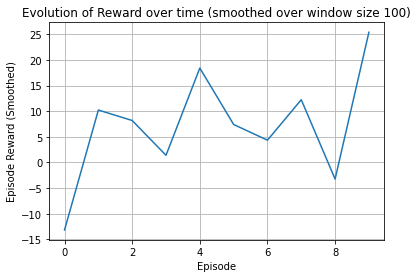

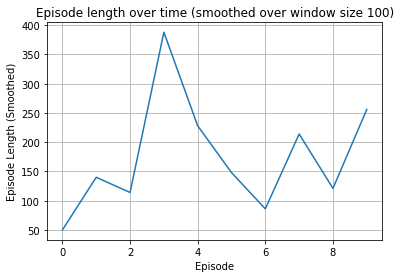

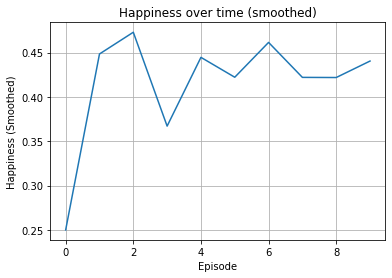

  2%|▏         | 19/1000 [00:00<00:52, 18.75it/s]

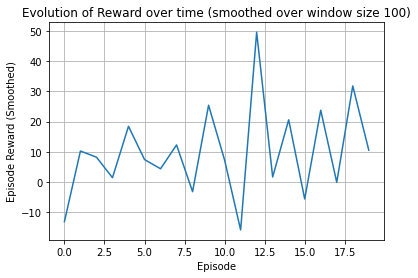

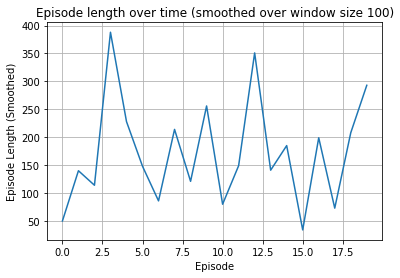

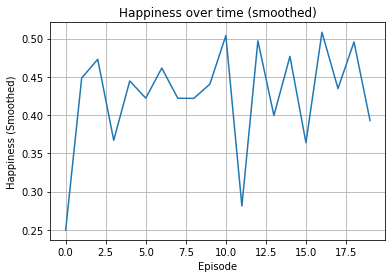

  3%|▎         | 29/1000 [00:01<01:07, 14.49it/s]

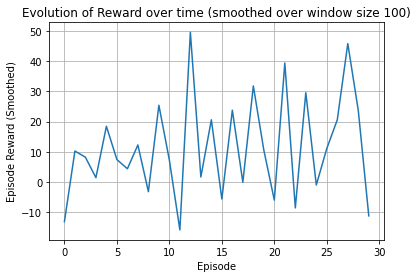

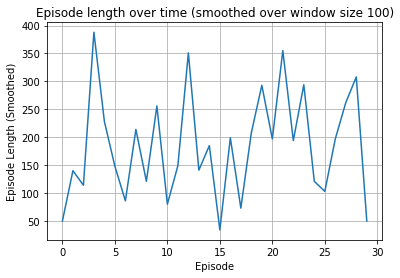

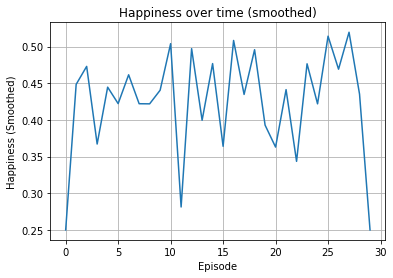

  4%|▍         | 39/1000 [00:02<01:39,  9.69it/s]

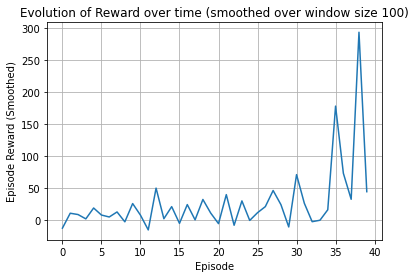

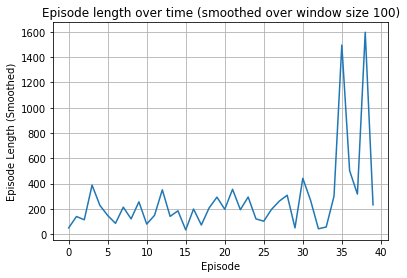

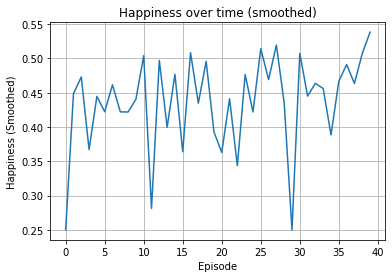

  5%|▍         | 48/1000 [00:04<01:45,  8.99it/s]

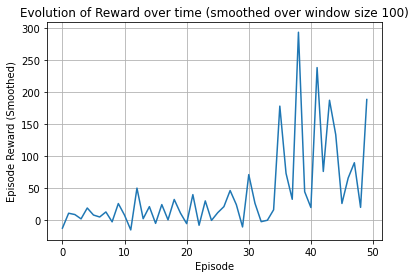

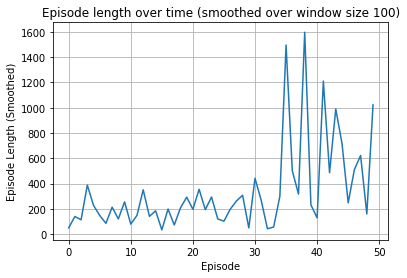

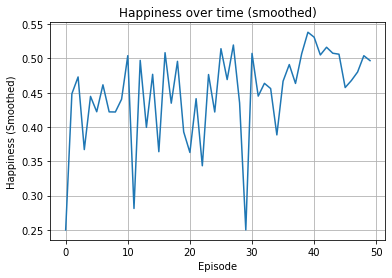

  6%|▌         | 59/1000 [00:08<04:38,  3.38it/s]

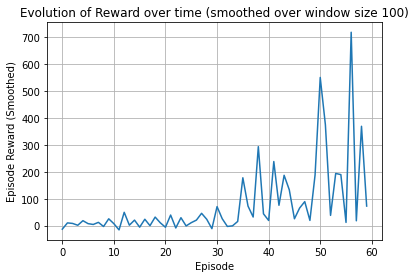

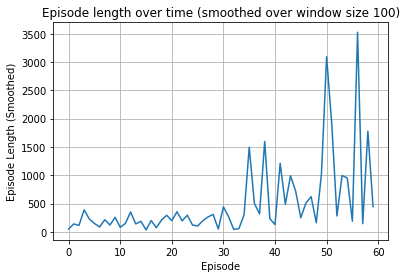

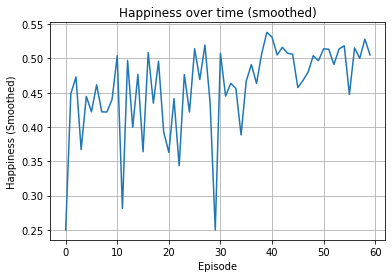

  7%|▋         | 69/1000 [00:11<04:35,  3.38it/s]

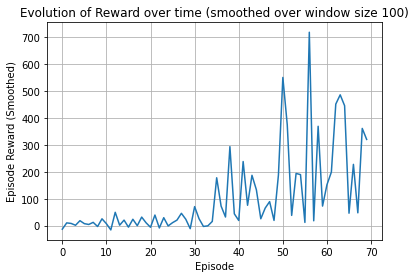

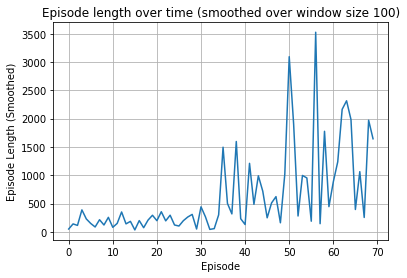

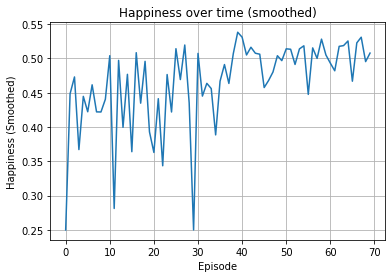

  8%|▊         | 79/1000 [00:18<07:48,  1.97it/s]

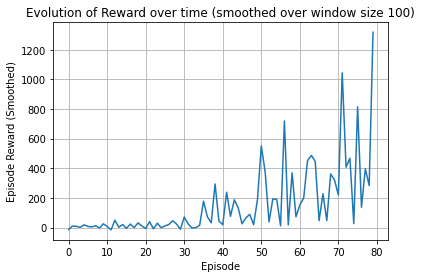

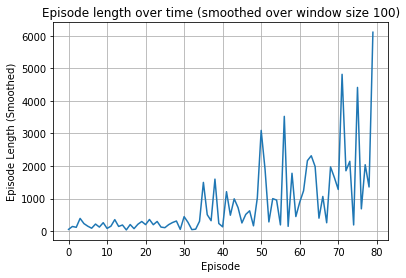

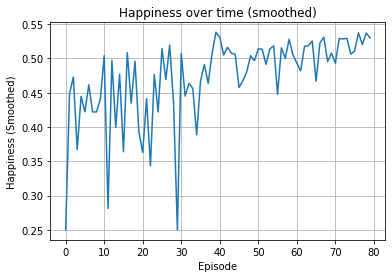

  9%|▉         | 89/1000 [00:27<25:31,  1.68s/it]

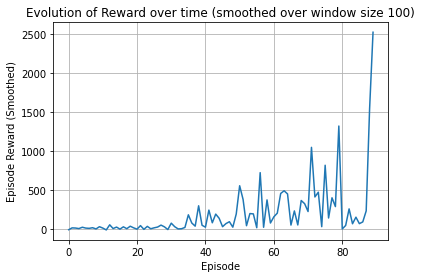

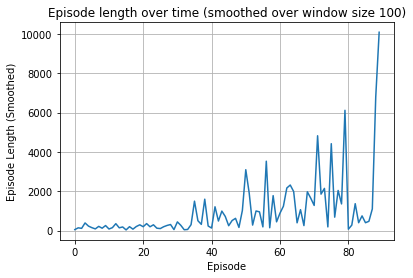

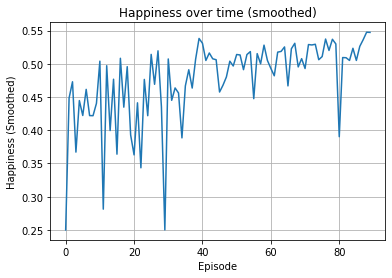

 10%|▉         | 99/1000 [01:02<49:06,  3.27s/it]  

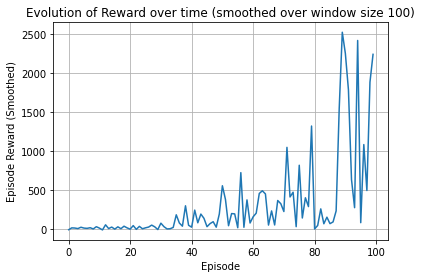

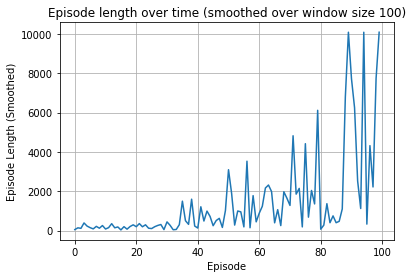

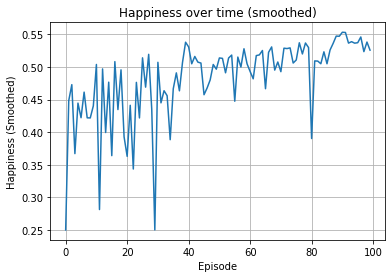

 10%|█         | 102/1000 [01:15<11:01,  1.36it/s]  


KeyboardInterrupt: 

In [29]:
# Starting the SARSA learning 
for episode in tqdm(range(n_episodes)):
    
    n_episode_steps = 0
    done = False

    # Update parameters
    epsilon = get_epsilon(episode, init_epsilon)
    alpha = get_alpha(episode, init_alpha)
    
    episode_reward = 0
    evolution_happiness = []
    
    # Get episode
    steps_episode = []

    state1 = env_reset()
    evolution_happiness.append(get_happiness(state1))
    action1 = epsilon_greedy(Q, state1['state_id'], n_actions, init_epsilon)

    while (not done) and (n_episode_steps < nmax_steps):

        # Getting the next state 
        state2, reward1, done, info = env_step(state1, action1)
        episode_reward += reward1
        evolution_happiness.append(get_happiness(state2))
        
        steps_episode.append({
            'state': state1,
            'action': action1,
            'reward' : reward1})

        # Choosing the next action
        action2 = epsilon_greedy(Q, state2['state_id'], n_actions, epsilon)

        # Updating the respective values 
        state1 = state2 
        action1 = action2
        n_episode_steps += 1
    
    # Add discounted reward
    add_discounted_reward(steps_episode, gamma)

    # Update N and Q
    states_already_visited = []
    for step_episode in steps_episode:
        # step_episode = steps_episode[0]
        update_N(N, step_episode, method_monte_carlo, states_already_visited)
        update_Q(Q, N, step_episode, method_monte_carlo, states_already_visited)
        states_already_visited.append(step_episode['state']['state_id'])
        
    # At the end of learning process 
    if render_episode:
        print('Episode {0}, Score: {1}, Timesteps: {2}, Epsilon: {3}, Alpha: {4}'.format(
            episode+1, episode_reward, n_episode_steps, epsilon, alpha))
    
    evolution_reward.append(episode_reward)
    evolution_steps.append(n_episode_steps)
    evolution_happiness_all.append(np.mean(evolution_happiness))
    
    if ((episode+1) % n_episodes_plot == 0):
        plot_evolution_reward(evolution_reward)
        plot_evolution_steps(evolution_steps)
        plot_evolution_happiness(evolution_happiness_all)

In [30]:
pct_state_visited = len(Q)/(101*101*101)*100
print(pct_state_visited)

1.1131698406582153


In [31]:
Q

defaultdict(<function __main__.init_Q.<locals>.get_default_Q_values()>,
            {'0.5000_0.0000_0.5000_True': array([4.49936942, 3.07881177, 2.60561846, 3.3464037 ]),
             '0.4900_0.0000_0.4900_False': array([-0.36509586,  0.        ,  0.        ,  2.80325695]),
             '0.4800_0.0000_0.4800_False': array([1.73452598, 3.52861309, 2.22108585, 0.        ]),
             '0.4700_0.0000_0.4700_False': array([3.64070625, 0.53874264, 2.71494714, 0.        ]),
             '0.4600_0.0000_0.4600_False': array([ 1.79479694,  3.36987152, -1.46434857,  0.        ]),
             '0.4500_0.0000_0.5700_True': array([ 0.        , -0.90799116,  3.92968786,  1.12563276]),
             '0.4400_0.0000_0.5600_False': array([ 0.        ,  3.42054285,  0.        , -1.92503997]),
             '0.4300_0.0000_0.5500_False': array([ 0.40759785,  0.        , -1.95267365,  0.        ]),
             '0.4200_0.0000_0.5400_False': array([ 0.        , -1.97123542,  3.67671773,  0.        ]),
      

# Evaluating the performance

## Mean reward

In [32]:
# Evaluating the performance 
print ("Performance : ", sum(evolution_reward)/n_episodes) 

Performance :  31.635780000000036


## Evolution of Reward overtime

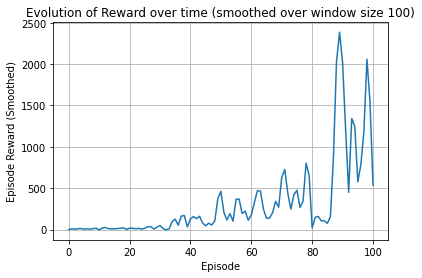

In [33]:
plot_evolution_reward(evolution_reward)

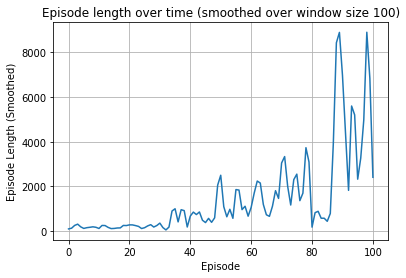

In [34]:
plot_evolution_steps(evolution_steps)

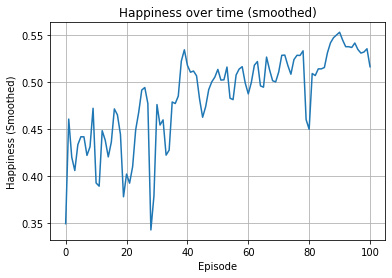

In [35]:
plot_evolution_happiness(evolution_happiness_all)

## Evaluation through episode

### One

In [36]:
# Variables
nmax_steps = 20000000

n_episode_steps = 0
evolution_episode_reward = []
done = False

# Start episode and get initial observation
state = env_reset()

while (not done) and (n_episode_steps < nmax_steps):

    # Get an action (0:Left, 1:Down, 2:Right, 3:Up)
    action = select_best_action(Q_state = Q[state['state_id']])

    # Perform a step
    state, reward, done, info = env_step(state, action)

    # Update score
    evolution_episode_reward.append(reward)
    n_episode_steps += 1

print('Test Episode, Score: {0}, Timesteps: {1}'.format(
    sum(evolution_episode_reward)/n_episode_steps, n_episode_steps))

plot_evolution_reward(evolution_episode_reward)

KeyboardInterrupt: 

### Multiple

In [54]:
# Variables
episodes = 10000
nmax_steps = 200000
total_reward = []

In [ ]:
# Loop episodes
for episode in tqdm(range(episodes)):

    n_episode_steps = 0
    evolution_episode_reward = []
    evolution_dog_happines = []
    done = False
    
    # Start episode and get initial observation
    state = env_reset()
    evolution_dog_happines.append(get_happiness(state))
    
    while (not done) and (n_episode_steps < nmax_steps):

        # Get an action (0:Left, 1:Down, 2:Right, 3:Up)
        action = select_best_action(Q_state = Q[state['state_id']])
        
        # Perform a step
        state, reward, done, info = env_step(state, action)
        evolution_dog_happines.append(get_happiness(state))
        
        # Update score
        evolution_episode_reward.append(reward)
        n_episode_steps += 1

    #print('Episode {0}, Score: {1}, Timesteps: {2}'.format(
    #    episode+1, sum(evolution_episode_reward)/n_episode_steps, n_episode_steps))
    
    #plot_evolution_reward(evolution_dog_happines)
    total_reward.append(sum(evolution_dog_happines)/n_episode_steps)

In [56]:
# Print the score
print('--- Evaluation ---')
print ('Score: {0} +/- {1}'.format(np.mean(total_reward), statistics.stdev(total_reward)))
print()

--- Evaluation ---
Score: 0.5891133000002426 +/- 0.0



In [39]:
state1

{'food': 0.68,
 'fat': 0.32,
 'affection': 0.71,
 'last_action_taken': 1,
 'minutes_since_last_action': 3,
 'can_action_be_taken': False,
 'state_id': '0.6800_0.3200_0.7100_False'}

In [40]:
Q

defaultdict(<function __main__.init_Q.<locals>.get_default_Q_values()>,
            {'0.5000_0.0000_0.5000_True': array([4.90627587, 3.85955495, 5.95215415, 5.73939075]),
             '0.4900_0.0000_0.4900_True': array([4.66100261, 1.42842399, 0.        , 0.        ]),
             '0.4800_0.0000_0.4800_True': array([-0.81212776, -1.31265708,  3.73305162,  4.44582333]),
             '0.4700_0.0000_0.4700_False': array([1.96309306, 4.21071948, 0.        , 2.08204805]),
             '0.4600_0.0000_0.4600_False': array([0.36991164, 4.18071274, 4.45821774, 0.        ]),
             '0.4500_0.0000_0.4500_False': array([3.73254468, 2.09215423, 3.92181334, 4.21863147]),
             '0.4400_0.0000_0.4400_False': array([0.30087784, 3.50632479, 4.42644283, 0.        ]),
             '0.4300_0.0000_0.5500_True': array([-1.33835463,  0.        ,  0.        ,  5.4877607 ]),
             '0.4200_0.0000_0.5400_False': array([0.        , 5.51379744, 0.        , 4.23028334]),
             '0.4100_0.0

In [41]:
state0 = env_reset()

In [42]:
state1, reward, _, _  = env_step(state0, action = 0)

In [43]:
state1, reward, _, _  = env_step(state1, action = 0)

In [44]:
state1

{'food': 0.48,
 'fat': 0,
 'affection': 0.48,
 'last_action_taken': 0,
 'minutes_since_last_action': 2,
 'can_action_be_taken': True,
 'state_id': '0.4800_0.0000_0.4800_True'}

In [45]:
for i in range(100):
    state1, reward, done, _  = env_step(state1, action = 2)
    print(state1)
    print(done)

{'food': 0.47, 'fat': 0, 'affection': 0.47, 'last_action_taken': 2, 'minutes_since_last_action': 0, 'can_action_be_taken': False, 'state_id': '0.4700_0.0000_0.4700_False'}
False
{'food': 1.0, 'fat': 0.25, 'affection': 0.46, 'last_action_taken': 2, 'minutes_since_last_action': 1, 'can_action_be_taken': True, 'state_id': '1.0000_0.2500_0.4600_True'}
False
{'food': 0.99, 'fat': 0.25, 'affection': 0.45, 'last_action_taken': 2, 'minutes_since_last_action': 0, 'can_action_be_taken': False, 'state_id': '0.9900_0.2500_0.4500_False'}
False
{'food': 1.0, 'fat': 0.5, 'affection': 0.44, 'last_action_taken': 2, 'minutes_since_last_action': 1, 'can_action_be_taken': True, 'state_id': '1.0000_0.5000_0.4400_True'}
False
{'food': 0.99, 'fat': 0.5, 'affection': 0.43, 'last_action_taken': 2, 'minutes_since_last_action': 0, 'can_action_be_taken': False, 'state_id': '0.9900_0.5000_0.4300_False'}
False
{'food': 1.0, 'fat': 0.75, 'affection': 0.42, 'last_action_taken': 2, 'minutes_since_last_action': 1, 'can

In [46]:
state1

{'food': 1.0,
 'fat': 1.0,
 'affection': 0.0,
 'last_action_taken': 2,
 'minutes_since_last_action': 1,
 'can_action_be_taken': True,
 'state_id': '1.0000_1.0000_0.0000_True'}

In [47]:
get_happiness(state1)

0.0

In [48]:
import dill

In [49]:
import pickle

In [50]:
pickle.dumps(Q)

AttributeError: Can't pickle local object 'init_Q.<locals>.get_default_Q_values'